In [1]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import gym
import matplotlib.pyplot as plt

from abides_gym_market_making_environment_v2 import *
from policies_v1 import SigPolicy
from train_v2 import train
import utils

## Register the environment

In [2]:
# register market making env for gym use 
from gym.envs.registration import register

register(
    id="market-making-v2",
    entry_point=SubGymMarketsMarketMakingEnv_v2,
)

def generate_env(seed):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(
            "market-making-v2",
            background_config="rmsc04",
            mkt_close="10:45:00",
            timestep_duration="10s",
            order_fixed_size=10,
            first_interval="00:10:00", #00:13:00
            observe_first_interval=True,
            max_inventory=100,
            mkt_order_alpha=0.2,
            terminal_inventory_reward=2,# reward
            inventory_reward_dampener=1., # 0.6,
            damp_mode="asymmetric",
            debug_mode=False
        )

    env.seed(seed)
    
    return env

# create the environment
env = generate_env(5)

## Signature policy

In [3]:
episodes = 250
lr = 0.0001
window_length = None
eps = 1.0
eps_decay = utils.linear_decay(epochs=20_000, start=eps, end=0.02)

sigpolicy = SigPolicy(env, 5)
sigpolicy.initialize_parameters(factor=1, zero_bias=True)

results = train(env, 
                sigpolicy, 
                episodes,
                discount=1.0,
                learning_rate=lr, 
                exploration="greedy",
                epsilon=eps,
                epsilon_decay=eps_decay,
                window_length=window_length, 
                printing=False)

  0%|          | 0/250 [00:00<?, ?it/s]
 Episode 0 | step 100 | reward -0.17080000000000004 | loss 0.1142393920680489
Q values: tensor([-0.0330,  0.0762,  0.0520, -0.0368], grad_fn=<SelectBackward>)

 Episode 0 | step 200 | reward -0.4857000000000001 | loss 0.1825425546917383
Q values: tensor([-0.0106,  0.0459,  0.0081,  0.0193], grad_fn=<SelectBackward>)

 Episode 0 | step 300 | reward -0.7806500000000003 | loss 0.23995045668633241
Q values: tensor([0.0424, 0.0327, 0.0271, 0.0459], grad_fn=<SelectBackward>)

 Episode 0 | step 361 | reward -1.5532000000000004 | loss 0.28957069294903914
Q values: tensor([0.0182, 0.1096, 0.0757, 0.1244], grad_fn=<SelectBackward>)
  0%|          | 1/250 [00:25<1:45:52, 25.51s/it]
 Episode 1 | step 400 | reward -0.07350000000000001 | loss 0.01356281045261841
Q values: tensor([ 0.0089, -0.0050,  0.0031,  0.0247], grad_fn=<SelectBackward>)

 Episode 1 | step 500 | reward -0.48610000000000014 | loss 0.059415992905918716
Q values: tensor([-0.0032,  0.0253,  0.

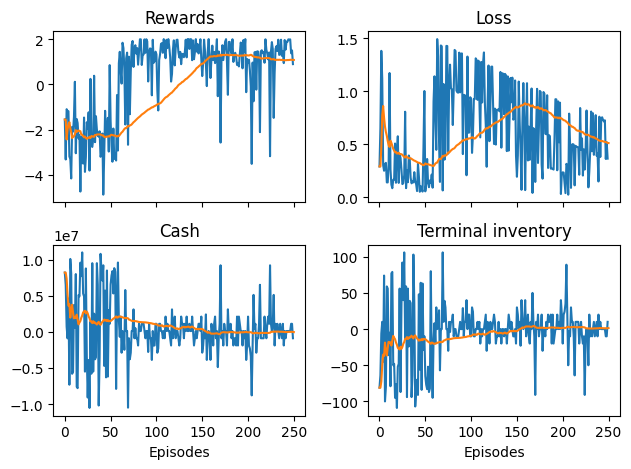

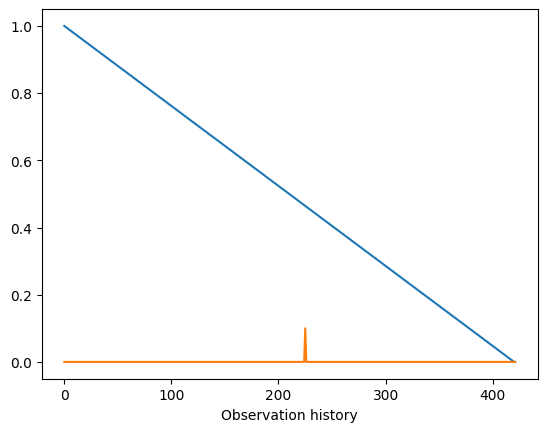

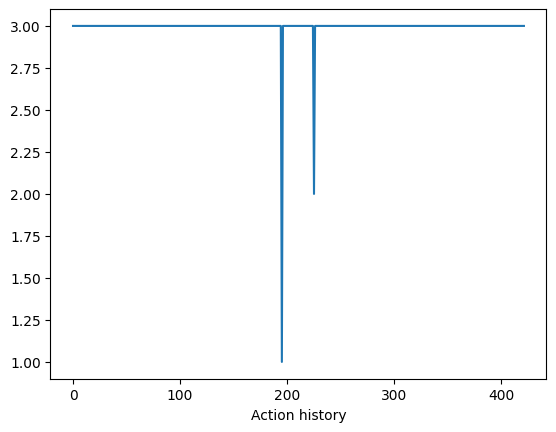

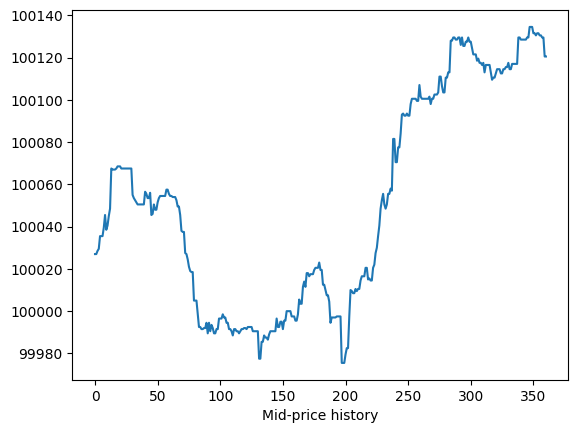

In [13]:

utils.plot_results([
    #results["rewards"],
    [x if abs(x) < 400 else 0 for x in results["rewards"]],
    #results["losses"],
    [x if abs(x) < 2000 else 200 for x in results["losses"]],
    results["cash"],
    results["terminal_inventory"],
])

id = 135

observation_history = list(results["observations"][id])
plt.plot(observation_history)
plt.xlabel("Observation history")
plt.show()

plt.plot(results["actions"][id])
plt.xlabel("Action history")
plt.show()

plt.plot(results["mid_prices"][id])
plt.xlabel("Mid-price history")
plt.show()


[1.1995, 1.4155, 1.972, 1.1940000000000002, 2.0, 2.0, 1.566, 1.999, 1.9905, 1.0685000000000002, 1.941, 1.1105000000000003, 1.4260000000000002, 1.999, 1.45]


AttributeError: 'SubGymMarketsMarketMakingEnv_v2' object has no attribute 'something'

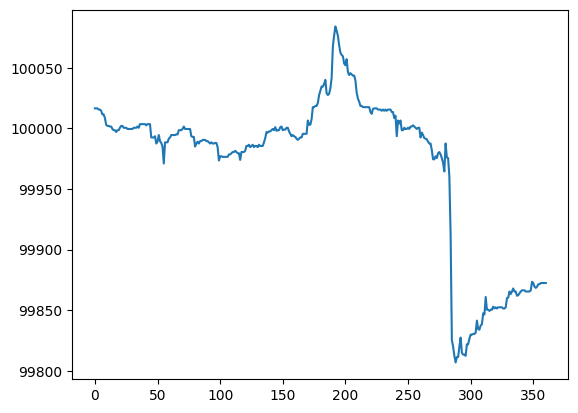

In [14]:
print(results["rewards"][130:145])
plt.plot(results["mid_prices"][1])

In [15]:
# results_reduced_100_runs_0804_1  # without inventory reward
# results_reduced_50_runs_0804_2  # with inventory reward
# results_reduced_50_runs_0804_3 # with inventory reward and correct epsilon decay
# results_v2_200_runs_0808_1_convergence # inventory only model, with some convergence
# results_v2_250_runs_0809_1 # inventory only model, with some convergence
# results_v2_250_runs_0809_2 # inventory only model, with some convergence
# results_v2_250_runs_0810_1 # inventory only model, with some convergence

import pickle

"""
# write results 
with open('../results/results_v2_250_runs_0810_1.pkl', 'wb') as f:  # open a text file
    pickle.dump(results, f) # serialize the list
f.close()


# load results
with open('../results/results_reduced_100_runs_0804_1.pkl', 'rb') as f:
    results = pickle.load(f)
f.close()
"""


"\n# load results\nwith open('../results/results_reduced_100_runs_0804_1.pkl', 'rb') as f:\n    results = pickle.load(f)\nf.close()\n"